# Here, we show you how to make a plot of radius versus frequency at a given timestep. With this plot, you can identify the approximate location of the corotation, inner and outer lindblad resonance for stars on circular orbits

## we'll show you how to do this with files in both the PSP and SPL formats, as there is a very slight difference!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import matplotlib.colors as colors
import matplotlib
plt.rcParams.update({'font.size': 22})
sys.path.insert(1, '')
sys.path.insert(1, '/home/filion/martinsims')
sys.path.insert(1, '/home/filion/martinsims/exptools/exptool')

from exptool.analysis import commensurability
from exptool.io import psp_io, spl_io,particle
from exptool.utils import utils
from exptool.utils import integrate
from exptool.basis import potential
from exptool.basis import eof
from exptool.utils import *
from exptool.orbits import *
from exptool.observables import visualize
from exptool.analysis import pattern
from exptool.io import outcoef

In [2]:
sim_path = '/usr/data/scylla/rmcclure/cca/sims/Run100/' 
#put the path to the directory where your simulation files live here!

In [3]:
#assuming PSP file format first! 
EOF2Dict = eof.read_binary_eof_coefficients_dict(sim_path+'outcoef.star.run2Fb')
#outcoef files should have this general naming scheme, 'outcoef.star.runSIMNAME'
# where here 'run2Fb' is the name of my simulation. 
DCp = eof.calculate_eof_phase(EOF2Dict)
eof.print_eof_barfile(DCp,simulation_directory=sim_path,\
                        simulation_name='2Fb',morder=2,norder=2)

In [ ]:
#if you instead have SPL format files, run the following code instead:
'''
coef = outcoef.OutCoef(sim_path + 'outcoef.star.othersimname')
EOF2Dict = coef._repackage_cylindrical_coefficients_compatibility()
DCp = eof.calculate_eof_phase(EOF2Dict,filter=False)
eof.print_eof_barfile(DCp,simulation_directory=sim_path,\
                        simulation_name='othersimname',morder=2,norder=2) 


fileprefix = 'SPL'

F,patt,rotfreq = potential.get_fields(sim_path,'F2b',
                        intime,eof_file,sph_file,model_file,
        transform=transform,fileprefix=fileprefix)
F.save_field('field_file'+str(intime))
'''
#everything after this should be compatible for either format!

In [7]:
intime=400
transform = False
fileprefix = 'OUT'

F,patt,rotfreq = potential.get_fields(sim_path,'run2Fb', #simulation directory and name
                        intime, #what timestep do you want to compute these quantities for?
                        eof_file= sim_path +'eof.cache.fileF', #eof file path + name
                        sph_file = sim_path+'SLGridSph.cache.run2Fb', #sph file path + name
                        model_file = sim_path +'run100.model', #model path + name
                        transform=False, #transform to the bar frame?
                        fileprefix=fileprefix)
#F.save_field('field_file'+str(intime)) #save the field, if you want - can't hurt to have around

potential.Fields.total_coefficients: Computing centering (centering=True)
potential.Fields.total_coefficients: Using computed disk center for halo (mutual_center=True)
potential.Fields.total_coefficients: (x,y,z) = 0.00020,0.00010,-0.00000
eof.make_coefficients_multi: 16 processors, 62500 particles each.
eof.make_coefficients_multi: Accumulation took 7.52 seconds, or 7.52 microseconds per orbit.
sl.compute_coefficients: 16 processors, 625000 particles each.
[ 1.00730000e-06  1.10290253e+07  1.18700000e-12 -8.99051397e+00][ 1.00730000e-06  1.10290253e+07  1.18700000e-12 -8.99051397e+00]

[ 1.00730000e-06  1.10290253e+07  1.18700000e-12 -8.99051397e+00]
[ 1.00730000e-06  1.10290253e+07  1.18700000e-12 -8.99051397e+00]
[ 1.00730000e-06  1.10290253e+07  1.18700000e-12 -8.99051397e+00][ 1.00730000e-06  1.10290253e+07  1.18700000e-12 -8.99051397e+00]

[ 1.00730000e-06  1.10290253e+07  1.18700000e-12 -8.99051397e+00]
[ 1.00730000e-06  1.10290253e+07  1.18700000e-12 -8.99051397e+00]
[ 1.007300

In [8]:
#read in the barfile that you made above, we'll use this to get the pattern speed of the bar!
pattern_speed = pd.read_csv(sim_path+'2Fb_m2n2_barpos.dat', 
                                 sep='\s+',
                 header=None,names=['t','unphase','speed'])

In [15]:
scale_length = 0.01
#F = potential.restore_field(field_file_name) #if you want, you can read in a field file that you already saved
#following the steps above, here we'll use the field we just generated a few cells above this
F.resonance_positions(rvals=np.linspace(.1*scale_length,10*scale_length,300)) #compute omega and kappa, aka 
#the circular frequency and the epicyclic frequency
#or if you want, you can make a rotation curve over a range of radii using the line below:
#F.rotation_curve(rvals=np.linspace(.1*scale_length,10*scale_length,300)) 
##then compute circular frequency this way: circ_freq = F.total_rotation/F.rvals 
circ_freq = F.omega
kap = F.kappa #get epicyclic frequencies
rs = F.rvals #get range of radii
ps = pattern_speed['speed'][intime] #get pattern speed at this time

corot_idx = np.nanargmin(abs(circ_freq-ps)) #where are circular frequency and pattern speed closest?
ilr_idx = np.argmin(abs(circ_freq - ps - kap/2)) #where is circular frequency closest to pattern speed + 2*epicyclic?
olr_idx = np.argmin(abs(circ_freq - ps + kap/2)) #where is circular frequency closest to pattern speed - 2*epicyclic?
print(rs[corot_idx], 'corototation loc at ', intime) #print radius of corotation 
print(rs[ilr_idx], 'ILR loc at ', intime) #print radius of ILR
print(rs[olr_idx], 'OLR loc at ', intime) #print radius of OLR

0.026494983277591973 corototation loc at  400
0.004642140468227425 ILR loc at  400
0.04934113712374582 OLR loc at  400


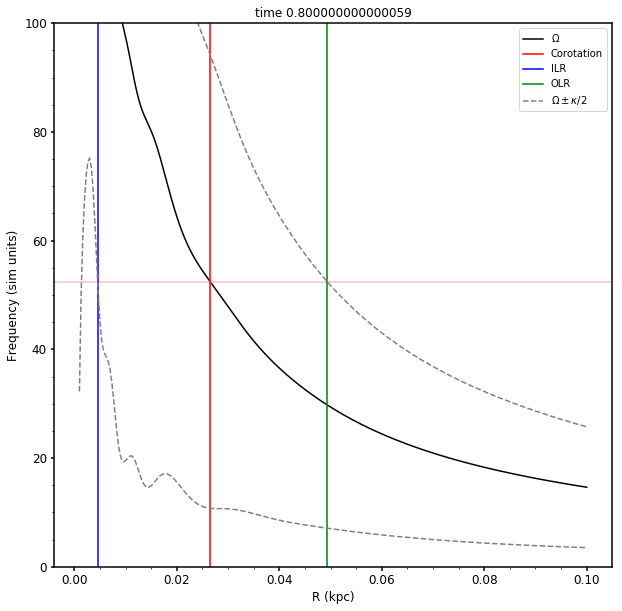

In [17]:
#now lets make a plot!
plt.figure(figsize=(10,10))
plt.title('time ' + str(pattern_speed['t'][intime]))
plt.plot(rs, circ_freq, c='k', label='$\Omega$')
plt.axhline(ps, c='pink')
plt.axvline(rs[corot_idx], c='r',label='Corotation')
plt.axvline(rs[ilr_idx], c='blue',label='ILR')
plt.axvline(rs[olr_idx], c='green',label='OLR')
plt.plot(rs, circ_freq - kap/2, c='grey',ls='--', label='$\Omega \pm \kappa/2$')
plt.plot(rs, circ_freq + kap/2, c='grey',ls='--')
plt.xlabel('R (kpc)')
plt.ylim(0,100)
plt.ylabel('Frequency (sim units)')
plt.legend()